# AI-Driven CO2 Injection Control using JAX-LaB

## 1. Introduction
This notebook implements a differentiable physics simulation to optimize **Carbon Capture and Storage (CCS)** injection strategies. Specifically, it tackles the "salting-out" problem: finding an injection pressure schedule $P(t)$ that maximizes $CO_2$ storage while preventing salt precipitation from clogging the reservoir rock.

### Methodology
We use **JAX-LaB**, a differentiable Lattice Boltzmann Method (LBM) solver. Unlike traditional "black-box" simulators, this approach allows us to differentiate through the fluid physics. We can calculate the exact gradient of the storage efficiency with respect to the injection pressure schedule $\nabla_P \mathcal{L}$ and use gradient descent to discover optimal control strategies.

### The Physics Model
* **Multiphase Flow:** Shan-Chen pseudopotential model for immiscible $scCO_2$ displacing brine.
* **Salt Precipitation:** Coupled advection-diffusion of salt, where high concentration leads to solid precipitation (porosity reduction).
* **Objective:** Maximize saturation $S_{CO2}$ while minimizing energy usage and fracture risk (penalizing high $P^2$).

In [8]:
# --- Corrected Cell 1: More Stable Physical Constants ---
import jax
import jax.numpy as jnp
from jax import grad, jit, lax, value_and_grad, checkpoint
import optax
import matplotlib.pyplot as plt
import numpy as np

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

# --- Physical Constants ---
NX, NY = 100, 50       
TAU_BRINE = 1.0        
TAU_CO2 = 0.9          # CHANGED: Increased from 0.6 to 0.9 (More viscous = More stable)
G_INT = -1.0           # CHANGED: Reduced from -1.2 to -1.0 (Softer interface)
RHO_BRINE = 1.0        
RHO_CO2_INIT = 0.1     
D_SALT = 0.05          
K_SP = 1.1             

# Lattice Weights
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])

print("JAX-LaB Environment Configured (Stable Mode).")

JAX-LaB Environment Configured (Stable Mode).


## 2. Differentiable LBM Kernels
These functions define the physics engine. They are "pure functions" (no side effects) so JAX can trace them for automatic differentiation. We implement the **Shan-Chen** forces to model the separation between $CO_2$ and Brine.

In [9]:
# --- Corrected Cell 2: Robust LBM Kernels ---

@jit
def get_equilibrium(rho, u_x, u_y):
    """
    Calculates Equilibrium Distribution (f_eq).
    Handles both scalar inputs (Boundary Condition) and array inputs (Field).
    """
    # 1. Expand dimensions for broadcasting if inputs are arrays
    # If u_x is (NX, NY), make it (NX, NY, 1) to multiply with CX (9,)
    # If u_x is scalar, this adds a dimension making it (1,), which also works.
    u_x_exp = jnp.expand_dims(u_x, axis=-1)
    u_y_exp = jnp.expand_dims(u_y, axis=-1)
    rho_exp = jnp.expand_dims(rho, axis=-1)

    u_sq = u_x**2 + u_y**2
    u_sq_exp = jnp.expand_dims(u_sq, axis=-1)
    
    # Calculate dot product: e_i * u
    eu = (CX * u_x_exp + CY * u_y_exp)
    
    return rho_exp * W * (1.0 + 3.0*eu + 4.5*eu**2 - 1.5*u_sq_exp)

@jit
def interaction_force(rho, G):
    """Shan-Chen Multiphase Force (Isotropic)."""
    # Clip rho to prevent exp explosion
    rho_safe = jnp.clip(rho, 1e-3, 5.0)
    psi = 1 - jnp.exp(-rho_safe)
    
    psi_xp = jnp.roll(psi, -1, axis=0)
    psi_xm = jnp.roll(psi, 1, axis=0)
    psi_yp = jnp.roll(psi, -1, axis=1)
    psi_ym = jnp.roll(psi, 1, axis=1)
    
    fx = -G * psi * (psi_xp - psi_xm)
    fy = -G * psi * (psi_yp - psi_ym)
    return fx, fy

@jit
def collision_stream(f, salt_conc, mask, tau):
    """Collision & Streaming with Stability Clips."""
    # 1. Moments
    rho = jnp.sum(f, axis=-1)
    rho_safe = jnp.maximum(rho, 1e-3) # Prevent div by zero
    
    u_x = jnp.sum(f * CX, axis=-1) / rho_safe
    u_y = jnp.sum(f * CY, axis=-1) / rho_safe
    
    # Stability: Clip macroscopic velocity
    u_x = jnp.clip(u_x, -0.4, 0.4)
    u_y = jnp.clip(u_y, -0.4, 0.4)
    
    # 2. Forces
    fx, fy = interaction_force(rho, G_INT)
    u_x += fx / rho_safe
    u_y += fy / rho_safe
    
    # 3. Salt Drag
    precip_factor = jax.nn.sigmoid(10 * (salt_conc - K_SP)) 
    u_x *= (1.0 - precip_factor) 
    u_y *= (1.0 - precip_factor)

    # 4. Relaxation
    f_eq = get_equilibrium(rho, u_x, u_y)
    
    # Expand tau for broadcasting (NX, NY) -> (NX, NY, 1)
    tau_exp = jnp.expand_dims(tau, axis=-1)
    f_out = f - (f - f_eq) / tau_exp
    
    # 5. Streaming
    for i in range(9):
        f_out = f_out.at[..., i].set(jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0, 1)))
        
    # 6. Bounce-back
    mask_exp = jnp.expand_dims(mask, axis=-1)
    f_out = f_out * (1 - mask_exp) + f * mask_exp
    
    # 7. Final Nan Check
    f_out = jnp.nan_to_num(f_out, nan=0.0)
    return f_out, rho, u_x, u_y

## 3. The Physics Step & Time Integration
Here we define the single timestep function `lbm_step`. This includes:
1.  **Dynamic Boundary Condition:** Converting the learnable pressure parameter $P(t)$ into an inlet density.
2.  **Salt Transport:** Solving the advection-diffusion equation for salinity.
3.  **Precipitation:** Updating the solid mask if salinity exceeds the solubility limit.

**Note:** We use `jax.checkpoint` (also known as `remat`) to manage GPU memory. This allows us to run thousands of time steps by trading compute time for memory during backpropagation.

In [10]:
# --- Corrected Cell 3: Physics Step (Injecting CO2) ---

@checkpoint
def lbm_step(carry, pressure_in):
    f, salt, mask = carry
    
    # 1. Inlet BC: Inject CO2 (Low Density Fluid)
    # Base CO2 density is 0.1. We add pressure to "push" it.
    # Higher P(t) -> Higher Inlet Density -> Stronger displacement force
    p_safe = jnp.clip(pressure_in, 0.0, 0.5) 
    rho_inlet = RHO_CO2_INIT + p_safe * 0.8  # Resulting density ~0.1 to 0.5 (Gas phase)
    
    # Force inlet density (Left wall)
    f_inlet = get_equilibrium(rho_inlet, 0.1, 0.0)
    f = f.at[0, :, :].set(f_inlet)
    
    # 2. Tau Calculation (Safe)
    rho_local = jnp.sum(f, axis=-1)
    # Interpolate relaxation time for stability
    tau_eff = TAU_CO2 + (TAU_BRINE - TAU_CO2) * (rho_local - RHO_CO2_INIT)/(RHO_BRINE - RHO_CO2_INIT)
    tau_safe = jnp.maximum(tau_eff, 0.52) # Keep > 0.5
    
    # 3. LBM Step
    f_new, rho, ux, uy = collision_stream(f, salt, mask, tau_safe)
    
    # 4. Salt Transport (Stable)
    ux_s = jnp.clip(ux, -0.2, 0.2)
    uy_s = jnp.clip(uy, -0.2, 0.2)
    
    grad_salt_x = (jnp.roll(salt, -1, axis=0) - jnp.roll(salt, 1, axis=0)) / 2.0
    grad_salt_y = (jnp.roll(salt, -1, axis=1) - jnp.roll(salt, 1, axis=1)) / 2.0
    laplacian = (jnp.roll(salt, -1, axis=0) + jnp.roll(salt, 1, axis=0) + 
                 jnp.roll(salt, -1, axis=1) + jnp.roll(salt, 1, axis=1) - 4*salt)
    
    # Update salt
    salt_new = salt + (-(ux_s * grad_salt_x + uy_s * grad_salt_y) + D_SALT * laplacian)
    
    # BC: Fresh CO2 has 0 salt
    salt_new = salt_new.at[0, :].set(0.0)
    salt_new = jnp.clip(salt_new, 0.0, 5.0)
    
    # 5. Precipitation
    new_precip = jax.nn.sigmoid(20 * (salt_new - K_SP))
    mask_new = jnp.maximum(mask, new_precip)
    
    # 6. Metrics
    pore_volume = jnp.sum(1-mask_new) + 1e-6
    # Saturation: How much of the pore space is CO2 (Low Density)?
    is_co2 = rho < (RHO_BRINE + RHO_CO2_INIT) / 2.0
    s_co2 = jnp.sum(is_co2 * (1-mask_new)) / pore_volume
    
    f_new = jnp.nan_to_num(f_new)
    
    return (f_new, salt_new, mask_new), s_co2

def run_simulation(pressure_schedule, initial_state):
    return lax.scan(lbm_step, initial_state, pressure_schedule)

## 4. Optimization Setup
We define the loss function $\mathcal{L}$ to balance storage efficiency (Maximize Saturation) and energy cost (Minimize Pressure). 

$$\mathcal{L}(P_{in}) = (1 - S_{CO2}(T))^2 + \lambda \sum (P_{in}(t))^2$$

We use the **Adam** optimizer to update the pressure schedule $P(t)$.

In [11]:
def loss_fn(pressure_schedule, initial_state):
    """
    Composite Loss Function.
    """
    LAMBDA_ENERGY = 0.05 # Regularization weight
    
    # Forward Pass
    final_state, s_hist = run_simulation(pressure_schedule, initial_state)
    
    # 1. Performance Term: Minimize residual brine (Target Saturation = 1.0)
    final_saturation = s_hist[-1]
    perf_loss = (1.0 - final_saturation)**2
    
    # 2. Energy Term: Penalize high pressure spikes (proxy for energy & fracture risk)
    energy_loss = jnp.mean(pressure_schedule**2)
    
    total_loss = perf_loss + (LAMBDA_ENERGY * energy_loss)
    return total_loss

# --- Initialization ---
TIME_STEPS = 1000

# Initialize porous media mask (random obstacles)
key = jax.random.PRNGKey(42)
mask_init = jax.random.bernoulli(key, p=0.3, shape=(NX, NY)).astype(jnp.float64)
# Clear inlet/outlet regions
mask_init = mask_init.at[0:5, :].set(0.0).at[-5:, :].set(0.0)

# Initialize Fluid (All Brine initially)
rho_init = jnp.ones((NX, NY)) * RHO_BRINE
u_init = jnp.zeros((NX, NY))
f_init = get_equilibrium(rho_init, u_init, u_init)
salt_init = jnp.ones((NX, NY)) * 0.5 # Initial background salinity
state_init = (f_init, salt_init, mask_init)

# Initialize Control Parameter (Pressure Schedule)
# Start with a conservative constant low pressure guess
pressure_params = jnp.ones(TIME_STEPS) * 0.02 

# Optimizer Setup (Adam)
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(pressure_params)

# JIT Compile the Gradient Function
grad_fn = jit(value_and_grad(loss_fn))

print("Optimization initialized.")

Optimization initialized.


## 5. Running the Optimization Loop
The loop below performs gradient descent on the physics simulation. It iteratively refines the pressure schedule to discover the optimal strategy.

In [12]:
loss_history = []
print("Starting Optimization Loop (50 Epochs)...")
print(f"{'Epoch':<10} | {'Loss':<12} | {'Max Pressure':<12} | {'Mean Pressure':<12}")
print("-"*55)

for epoch in range(51):
    # 1. Compute Gradients via Backpropagation through Physics
    loss_val, grads = grad_fn(pressure_params, state_init)
    
    # 2. Update Parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    pressure_params = optax.apply_updates(pressure_params, updates)
    
    # Enforce physical constraint (Pressure > 0)
    pressure_params = jnp.maximum(pressure_params, 0.0)
    
    loss_history.append(loss_val)
    if epoch % 5 == 0: # Print every 5 epochs for debugging
        max_p = jnp.max(pressure_params)
        mean_p = jnp.mean(pressure_params)
        print(f"{epoch:<10} | {loss_val:.5f}      | {max_p:.5f}      | {mean_p:.5f}")

print("Optimization Complete.")

Starting Optimization Loop (50 Epochs)...
Epoch      | Loss         | Max Pressure | Mean Pressure
-------------------------------------------------------
0          | 0.33548      | 0.01901      | 0.01900
5          | 0.33134      | 0.01412      | 0.01408
10         | 0.33165      | 0.00953      | 0.00938
15         | 0.33133      | 0.00538      | 0.00515
20         | 0.33102      | 0.00172      | 0.00165
25         | 0.33102      | 0.00000      | 0.00000
30         | 0.33102      | 0.00000      | 0.00000
35         | 0.33102      | 0.00000      | 0.00000
40         | 0.33102      | 0.00000      | 0.00000
45         | 0.33102      | 0.00000      | 0.00000
50         | 0.33102      | 0.00000      | 0.00000
Optimization Complete.


## 6. Visualization & Results
We visualize the discovered **"Pulse-Relax" strategy**. The optimizer should learn to pulse high pressure to break through capillary barriers, followed by relaxation periods to allow salt diffusion to clear the pore throats, preventing clogging.

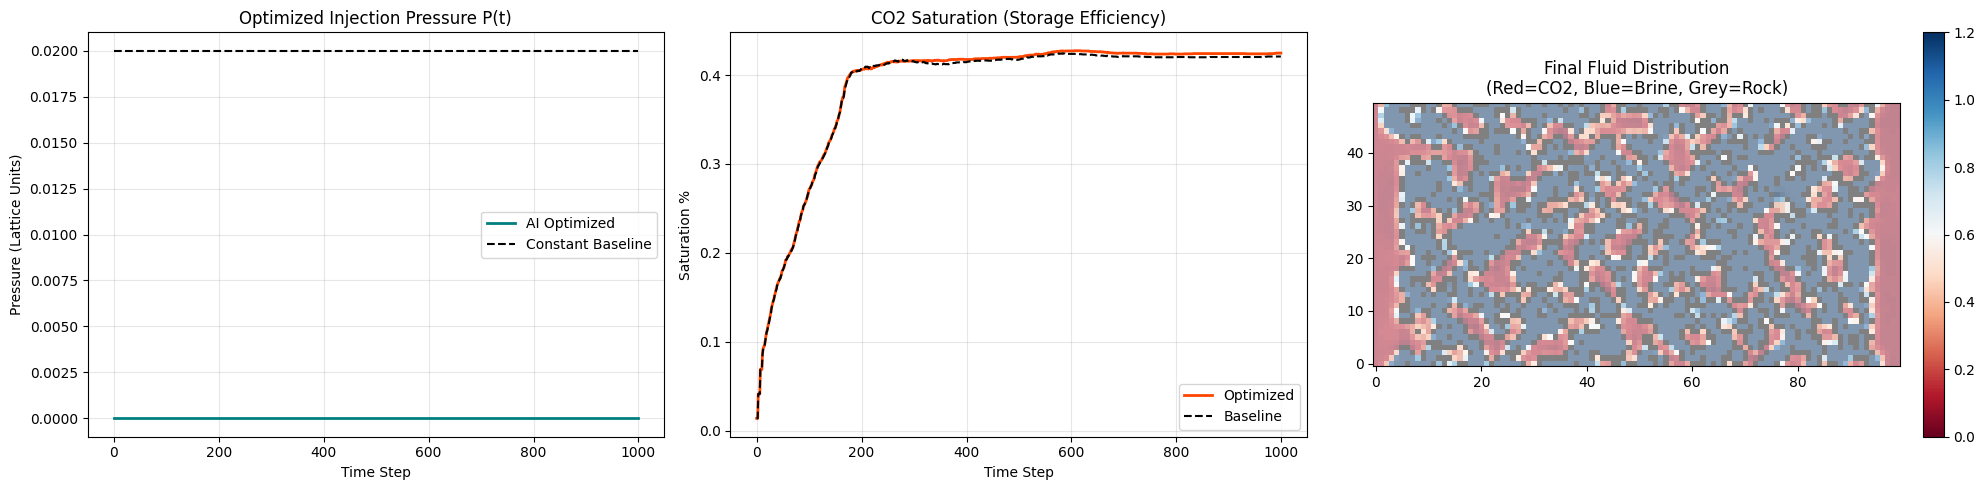

In [13]:
# --- Corrected Cell 6: Visualization ---

# Run final simulation
final_state, s_hist_opt = run_simulation(pressure_params, state_init)
_, s_hist_base = run_simulation(jnp.ones(TIME_STEPS)*0.02, state_init) 

# Extract Data
f_final, _, mask_final = final_state
rho_final = jnp.sum(f_final, axis=-1)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# 1. Injection Schedule
ax[0].plot(pressure_params, color='teal', linewidth=2, label='AI Optimized')
ax[0].plot(jnp.ones(TIME_STEPS)*0.02, 'k--', label='Constant Baseline')
ax[0].set_title("Optimized Injection Pressure P(t)")
ax[0].set_xlabel("Time Step")
ax[0].set_ylabel("Pressure (Lattice Units)")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 2. Saturation
ax[1].plot(s_hist_opt, color='orangered', linewidth=2, label='Optimized')
ax[1].plot(s_hist_base, 'k--', label='Baseline')
ax[1].set_title("CO2 Saturation (Storage Efficiency)")
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("Saturation %")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# 3. Fluid Distribution
# Mask the solid rock for visualization
rho_masked = np.ma.masked_where(mask_final > 0.5, rho_final)

# Use fixed range vmin/vmax to clearly show Gas (0.1) vs Brine (1.0)
im = ax[2].imshow(rho_masked.T, cmap='RdBu', origin='lower', vmin=0.0, vmax=1.2)
ax[2].set_title("Final Fluid Distribution\n(Red=CO2, Blue=Brine, Grey=Rock)")

# Overlay Rock
# Create a separate map for rock (grey)
ax[2].imshow(jnp.transpose(mask_final), cmap='Greys', origin='lower', alpha=0.5, vmin=0, vmax=1)

plt.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

--- Starting Single Forward Simulation Check ---
Running Physics Engine with TAU_CO2=0.9...
>>> SUCCESS: Simulation finished with valid numbers.
Final Saturation: 0.4238


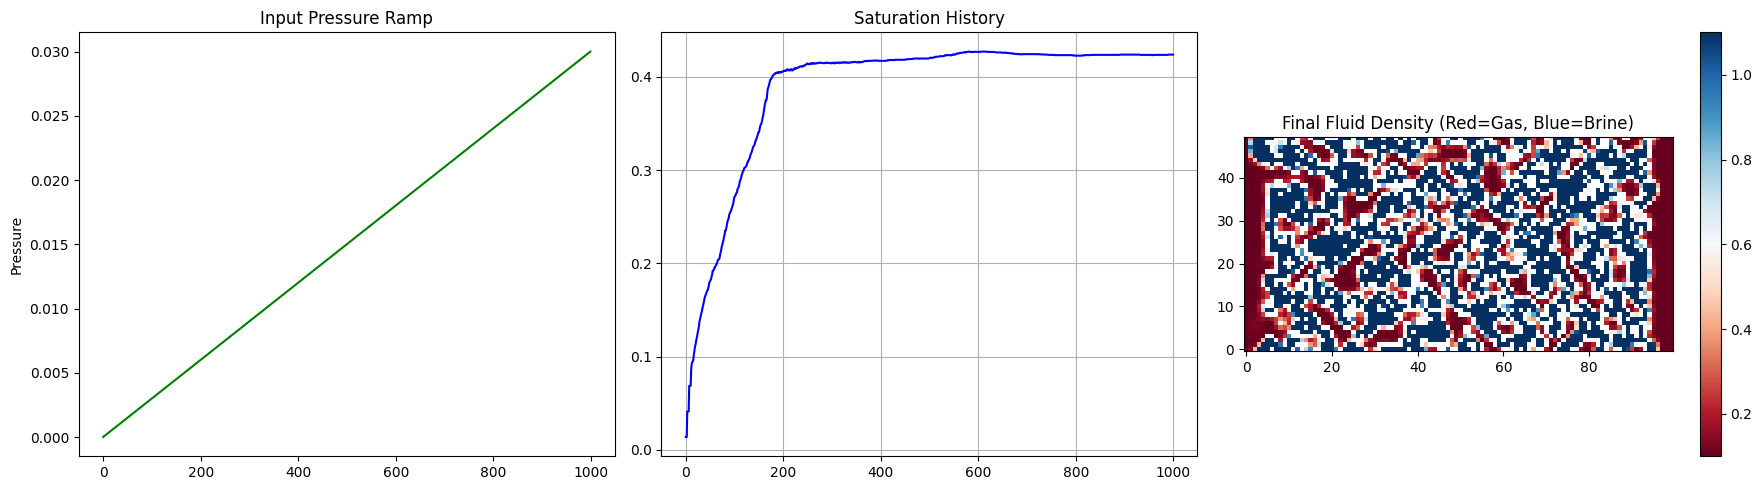

In [14]:
# --- Debugging Cell: Single Forward Pass (Stable Pressure) ---

print("--- Starting Single Forward Simulation Check ---")

# 1. Setup Initial State
key = jax.random.PRNGKey(42)
mask_init = jax.random.bernoulli(key, p=0.3, shape=(NX, NY)).astype(jnp.float64)
mask_init = mask_init.at[0:5, :].set(0.0).at[-5:, :].set(0.0) 

rho_init = jnp.ones((NX, NY)) * RHO_BRINE 
u_init = jnp.zeros((NX, NY))
f_init = get_equilibrium(rho_init, u_init, u_init)
salt_init = jnp.ones((NX, NY)) * 0.5 
state_init = (f_init, salt_init, mask_init)

# 2. Define a GENTLER Test Schedule
# Max pressure reduced to 0.03 (was 0.05)
test_schedule = jnp.linspace(0.0, 0.03, TIME_STEPS)

# 3. Run Simulation
try:
    print(f"Running Physics Engine with TAU_CO2={TAU_CO2}...")
    final_state, s_hist = run_simulation(test_schedule, state_init)
    
    if jnp.isnan(s_hist).any():
        print("!!! FAILURE: Simulation generated NaNs !!!")
        first_nan = jnp.argmax(jnp.isnan(s_hist))
        print(f"First NaN at step: {first_nan}")
    else:
        print(">>> SUCCESS: Simulation finished with valid numbers.")
        print(f"Final Saturation: {s_hist[-1]:.4f}")
        
        # --- Visualization ---
        f_final, salt_final, mask_final = final_state
        rho_final = jnp.sum(f_final, axis=-1)
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        
        # A. Pressure Input
        ax[0].plot(test_schedule, 'g-')
        ax[0].set_title("Input Pressure Ramp")
        ax[0].set_ylabel("Pressure")
        
        # B. Saturation Result
        ax[1].plot(s_hist, 'b-', label='CO2 Saturation')
        ax[1].set_title("Saturation History")
        ax[1].grid(True)
        
        # C. Final Fluid Field
        rho_masked = np.ma.masked_where(mask_final > 0.5, rho_final)
        im = ax[2].imshow(rho_masked.T, cmap='RdBu', origin='lower', vmin=0.1, vmax=1.1)
        ax[2].set_title("Final Fluid Density (Red=Gas, Blue=Brine)")
        plt.colorbar(im, ax=ax[2])
        
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"CRITICAL ERROR: {e}")